In [223]:
# ------------------------ import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import seaborn as sns

In [224]:
# ------------------------- import data
# importing dates and adjusted closing prices
ba = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\BA.csv", usecols = [0, 5])
intc = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\INTC.csv", usecols = [0, 5])
ko = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\KO.csv", usecols = [0, 5])
ms = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\MS.csv", usecols = [0, 5])
nflx = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\NFLX.csv", usecols = [0, 5])
nvda = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\NVDA.csv", usecols = [0, 5])

In [225]:
# --------------------------  rename adjusted closing pricing columns
tickers = ['BA', 'INTC', 'KO', 'MS', 'NFLX', 'NVDA']
dates = ['Date']
ticks = [ba, intc, ko, ms, nflx, nvda]
for i, j in zip(ticks, tickers):
    i.columns = ['Date', j] 


In [226]:
df = pd.concat(ticks, axis = 1)
dff = df.T.drop_duplicates().T

In [227]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1258 non-null   object
 1   BA      1258 non-null   object
 2   INTC    1258 non-null   object
 3   KO      1258 non-null   object
 4   MS      1258 non-null   object
 5   NFLX    1258 non-null   object
 6   NVDA    1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [228]:
# Our closing prices currently have object datatypes. This needs to be changed as we are dealing with numerical data.
ddata = pd.DataFrame(dff.iloc[:, 0], )
tdata = dff.iloc[:, 1:].astype('float64')

In [229]:
sdata = pd.concat([ddata, tdata], axis = 1).dropna().set_index('Date')

In [230]:
sdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2016-07-22 to 2021-07-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BA      1258 non-null   float64
 1   INTC    1258 non-null   float64
 2   KO      1258 non-null   float64
 3   MS      1258 non-null   float64
 4   NFLX    1258 non-null   float64
 5   NVDA    1258 non-null   float64
dtypes: float64(6)
memory usage: 68.8+ KB


In [231]:
#plot percentage changes in the closing prices
pdata = (sdata/sdata.iloc[0])*100
pdata.head()

,BA,INTC,KO,MS,NFLX,NVDA
Date,,,,,,
2016-07-22,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2016-07-25,99.602912,100.086544,99.432690,100.726151,102.060781,101.847477
2016-07-26,101.033951,101.240648,97.927151,101.071932,106.426831,103.585160
2016-07-27,101.865600,100.490464,94.697798,101.037102,107.160324,102.542522
2016-07-28,99.655344,100.317360,95.243302,100.480033,106.706256,102.762044


<AxesSubplot:xlabel='Date'>

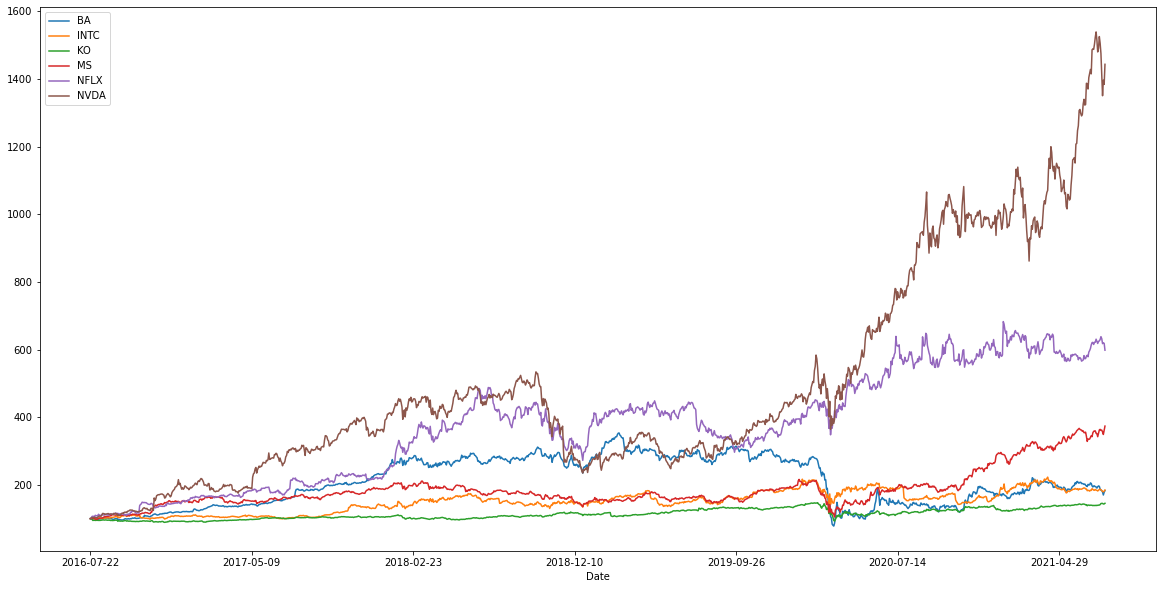

In [232]:
pdata.plot(figsize=(20, 10))

- We see that Nvidia has performed better than the other stocks. The growth rate of Nvidia stock price has picked up majorly after 2019. The stock with the lowest growth in stock prices is Coca Cola.

In [233]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers) )
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [234]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)


In [235]:
def portfolio_return(weights):
#        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=sdata.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=sdata.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=sdata.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=sdata.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    target = np.linspace(rp_min, 0.40, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)

In [236]:
returns = sdata.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.01136

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.48
Annualised Volatility: 0.32


              BA  INTC    KO     MS   NFLX   NVDA
allocation  1.08   0.2  1.76  23.02  36.36  37.57
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.19


             BA  INTC     KO    MS   NFLX  NVDA
allocation  0.3  11.4  62.15  5.09  17.44  3.63


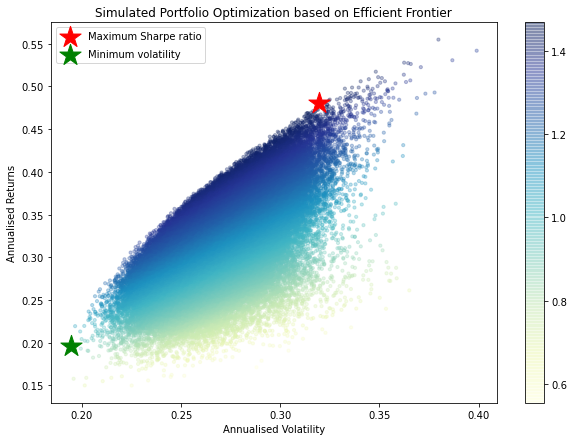

In [237]:
# Simulating Portfolios based on Efficient Frontier
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)